Epoch 1/150


C:\Users\Aman Deep Singh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 0.7015 - Precision: 0.5940 - Recall: 0.6423 - accuracy: 0.6441 - loss: 6.5392 - val_AUC: 0.8072 - val_Precision: 0.9279 - val_Recall: 0.3007 - val_accuracy: 0.6756 - val_loss: 5.8742 - learning_rate: 5.0000e-04
Epoch 2/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 0.7015 - Precision: 0.5940 - Recall: 0.6423 - accuracy: 0.6441 - loss: 6.5392 - val_AUC: 0.8072 - val_Precision: 0.9279 - val_Recall: 0.3007 - val_accuracy: 0.6756 - val_loss: 5.8742 - learning_rate: 5.0000e-04
Epoch 2/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7946 - Precision: 0.7051 - Recall: 0.6849 - accuracy: 0.7313 - loss: 5.2529 - val_AUC: 0.8362 - val_Precision: 1.0000 - val_Recall: 0.1562 - val_accuracy: 0.6212 - val_loss: 4.7747 - learning_rate: 5.0000e-04
Epoch 3/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7946 - Precision: 0.7051 - Recall: 0.6849 - accuracy: 0.7313 - loss: 5.2529 - val_AUC: 0.8362 - val_Precision: 1.0000 - val_Recall: 0.1562 - va

KeyError: 'auc_1'

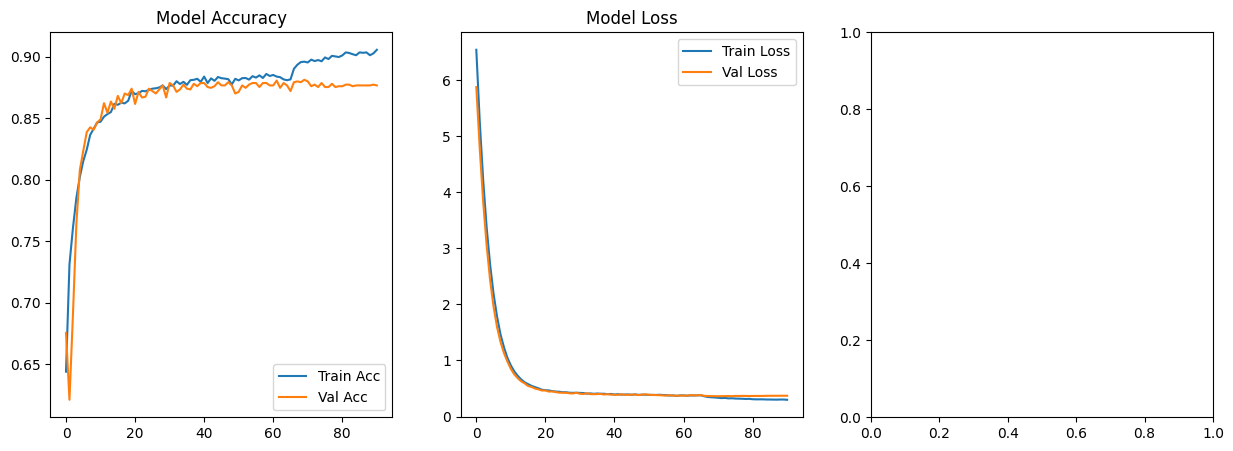

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load and preprocess data
data = pd.read_csv("Sheets/cybersecurity_intrusion_data.csv")
data = data.drop('session_id', axis=1)

# Enhanced Feature Engineering
data['failed_ratio'] = data['failed_logins'] / (data['login_attempts'] + 1)
data['data_rate'] = data['network_packet_size'] / (data['session_duration'] + 1)
data['high_risk'] = ((data['ip_reputation_score'] < 0.4) & 
                     (data['unusual_time_access'] > 0.6)).astype(int)
data['activity_score'] = (data['network_packet_size'] * data['login_attempts']) / \
                        (data['session_duration'] + 1)
data['risk_score'] = (1 - data['ip_reputation_score']) * data['unusual_time_access']
data['login_frequency'] = data['login_attempts'] / (data['session_duration'] + 1)
data['packet_size_per_login'] = data['network_packet_size'] / (data['login_attempts'] + 1)
data['risk_activity_ratio'] = data['risk_score'] * data['activity_score']

# Interaction features
data['high_risk_failed'] = data['high_risk'] * data['failed_ratio']
data['risk_login_freq'] = data['risk_score'] * data['login_frequency']

# Handle categorical features with improved encoding
categorical_cols = ['protocol_type', 'encryption_used', 'browser_type']
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Combine all features
data = pd.concat([data.drop(columns=categorical_cols).reset_index(drop=True),
                 encoded_df.reset_index(drop=True)], axis=1)

# Replace infinities and normalize features
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(data.mean())

X = data.drop('attack_detected', axis=1)
y = data['attack_detected']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Advanced preprocessing pipeline
scaler = StandardScaler()
power = PowerTransformer(method='yeo-johnson')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = power.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = power.transform(X_test_scaled)

# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Enhanced model architecture with residual-like connections
model = Sequential([
    # Input layer
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],),
          kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    
    # First hidden layer
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second hidden layer
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Third hidden layer
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile with optimized learning rate and metrics
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, 
             loss='binary_crossentropy',
             metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Advanced callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

# Train with class weights and advanced parameters
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
loss, accuracy, precision, recall, auc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Metrics:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"AUC: {auc:.4f}")

# Plot training history
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,3,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history['auc_1'], label='Train AUC')
plt.plot(history.history['val_auc_1'], label='Val AUC')
plt.title('Model AUC')
plt.legend()
plt.tight_layout()
plt.show()

# Generate predictions and detailed classification report
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Attack', 'Attack']))

# Plot enhanced confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Attack', 'Attack'],
            yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the improved model
model.save("cybersecurity_intrusion_ann_model_v2.h5")
print("\nImproved model saved as 'cybersecurity_intrusion_ann_model_v2.h5'")

# Print feature importance analysis
feature_importance = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

Epoch 1/300


C:\Users\Aman Deep Singh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 0.7008 - Precision: 0.5954 - Recall: 0.6456 - accuracy: 0.6457 - loss: 6.5583 - val_AUC: 0.7669 - val_Precision: 0.9268 - val_Recall: 0.1664 - val_accuracy: 0.6199 - val_loss: 5.9369 - learning_rate: 5.0000e-04
Epoch 2/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 0.7008 - Precision: 0.5954 - Recall: 0.6456 - accuracy: 0.6457 - loss: 6.5583 - val_AUC: 0.7669 - val_Precision: 0.9268 - val_Recall: 0.1664 - val_accuracy: 0.6199 - val_loss: 5.9369 - learning_rate: 5.0000e-04
Epoch 2/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7823 - Precision: 0.6946 - Recall: 0.6816 - accuracy: 0.7239 - loss: 5.3488 - val_AUC: 0.8156 - val_Precision: 1.0000 - val_Recall: 0.1226 - val_accuracy: 0.6062 - val_loss: 4.8954 - learning_rate: 5.0000e-04
Epoch 3/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7823 - Precision: 0.6946 - Recall: 0.6816 - accuracy: 0.7239 - loss: 5.3488 - val_AUC: 0.8156 - val_Precision: 1.0000 - val_Recall: 0.1226 - va

KeyError: 'auc'

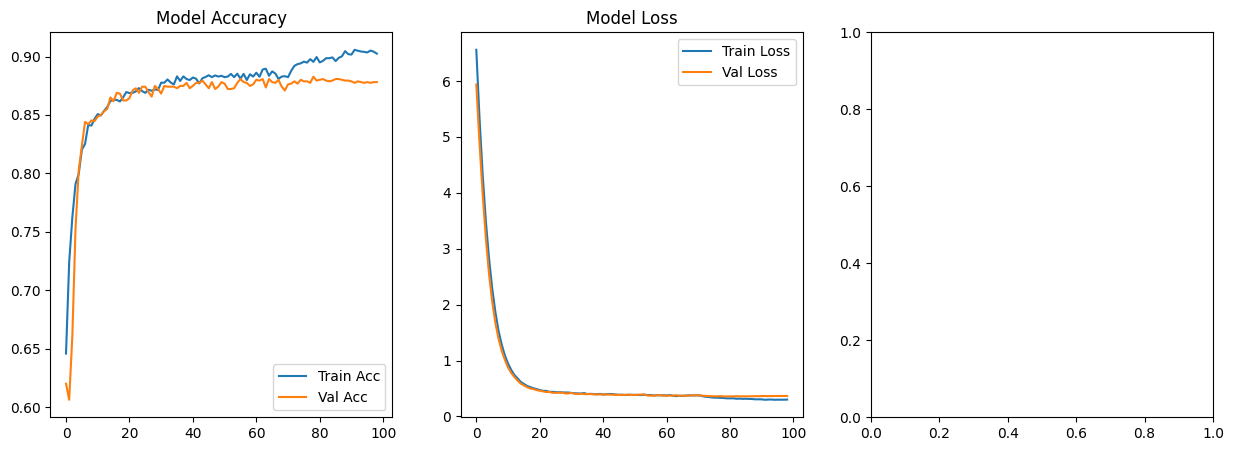

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load and preprocess data
data = pd.read_csv("Sheets/cybersecurity_intrusion_data.csv")
data = data.drop('session_id', axis=1)

# Enhanced Feature Engineering
data['failed_ratio'] = data['failed_logins'] / (data['login_attempts'] + 1)
data['data_rate'] = data['network_packet_size'] / (data['session_duration'] + 1)
data['high_risk'] = ((data['ip_reputation_score'] < 0.4) & 
                     (data['unusual_time_access'] > 0.6)).astype(int)
data['activity_score'] = (data['network_packet_size'] * data['login_attempts']) / \
                        (data['session_duration'] + 1)
data['risk_score'] = (1 - data['ip_reputation_score']) * data['unusual_time_access']
data['login_frequency'] = data['login_attempts'] / (data['session_duration'] + 1)
data['packet_size_per_login'] = data['network_packet_size'] / (data['login_attempts'] + 1)
data['risk_activity_ratio'] = data['risk_score'] * data['activity_score']

# Interaction features
data['high_risk_failed'] = data['high_risk'] * data['failed_ratio']
data['risk_login_freq'] = data['risk_score'] * data['login_frequency']

# Handle categorical features
categorical_cols = ['protocol_type', 'encryption_used', 'browser_type']
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Combine all features
data = pd.concat([data.drop(columns=categorical_cols).reset_index(drop=True),
                 encoded_df.reset_index(drop=True)], axis=1)

# Replace infinities and normalize features
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(data.mean())

X = data.drop('attack_detected', axis=1)
y = data['attack_detected']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
power = PowerTransformer(method='yeo-johnson')
X_train_scaled = power.fit_transform(scaler.fit_transform(X_train))
X_test_scaled = power.transform(scaler.transform(X_test))

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6, verbose=1)

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


# Plot training history
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,3,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Model AUC')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Attack', 'Attack']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Attack', 'Attack'],
            yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save model
model.save("cybersecurity_intrusion_ann_model_v2.h5")
print("\nImproved model saved as 'cybersecurity_intrusion_ann_model_v2.h5'")

# Feature importance
feature_importance = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()
